# Ciencia de datos aplicada

## Taller 8

### Contexto


Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book

Columns

1. age: age of primary beneficiary

2. sex: insurance contractor gender, female, male

3. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,objective index of body weight (kg / $m^2$) using the ratio of height to weight, ideally 18.5 to 24.9

4. children: Number of children covered by health insurance / Number of dependents

5. smoker: Smoking

6. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

7. charges: Individual medical costs billed by health insurance


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.optimize import linprog

### Extensión

1. Realice el análisis de sensitividad con python para la función  $y = a + b\cdot x^2$
2. Busque en grupo una solución al siguiente problema:
    * En un hospital un grupo de enfermos en recuperación debe llevar una dieta especial, el cual debe tener ciertos índices calóricos por la complejidad de su enfermedad, además alimentos ricos en vitaminas y minerales específicos para una pronta recuperación, esta dieta se debe componer de carne, papas, habichuela, leche y guayaba. Los precios por kilo son 700, 80, 250, 70 y 80 respectivamente. Este selecto grupo de enfermos se compone de 6 personas y cada persona debe consumir 800 calorías. Para que la alimentación sea adecuada se debe componer de 20% de proteinas, 30% de grasas y 50% de glúcidos, para facilitar el trabajo se tiene la siguiente tabla
    
|             | Proteinas | Grasas | Glúcidos |
|:-----------:|:---------:|:------:|:--------:|
|    Carne    |     10    |   10   |     0    |
|    Papas    |     2     |    0   |    20    |
| Habichuelas |     1     |    0   |     5    |
|    Leche    |     5     |    3   |     5    |
|   Guayaba   |     1     |    0   |    15    |

### Análisis de sensibilidad

Se trata de una función $f(x| a, b) = y$. La variable de respuesta es $y$ y la variable independiente $x$. Podemos estudiar la función desde un análisis a los parámetros $a$ y $b$, o sobre la variable $x$. Haremos el estudio sobre los parámetros.

Acotamos los valores posibles de $a$ entre -50 y 50.

In [2]:
# Definimos la función a estudiar.
def f(x, a, b):
    return a + b * x ** 2

# Planteamos las variables sobre las que queremos hacer el análisis
problem = {
    'num_vars': 2,
    'names': ['a', 'b'],
    'bounds': [[-50,  50 ],
               [-50, 50]]
}

# Hacemos un sampling de las variables.
param_values = saltelli.sample(problem, 2**12)

# Creamos el intervalo en x sobre el cual vamos a evaluar la función
x = np.linspace(-10, 10, 10000)

# Evaluamos la función para cada muestra, para cada valor del intervalo de x.
y = np.array([f(x, *params) for params in param_values])
    
# Imprimimos el resultado transpuesto de la ejecución.
# Esto resulta en un arreglo de tantas listas como valores de x en el intervalo.
# Cada lista contiene los y de su respectivo x, para cada valor de la muestra de los parámetros.
y.T

# Analizamos el problema, para cada x por separado. Esto produce un arreglo con los 
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

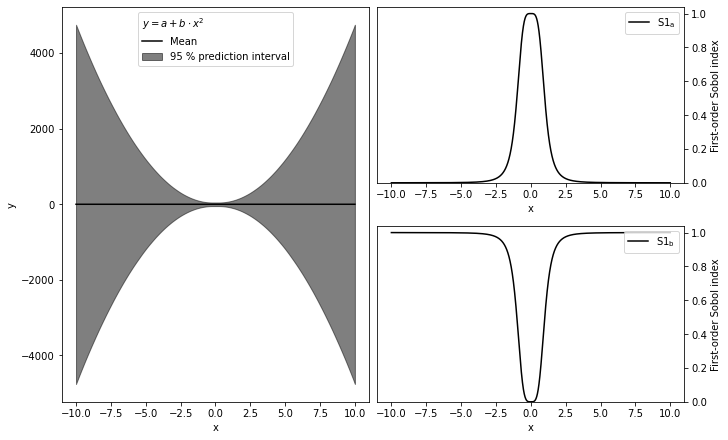

In [3]:
# Creamos el arreglo para cada x de los efectos de primer orden para a y b.
S1s = np.array([s['S1'] for s in sobol_indices])

# Creamos un layout de figuras de 2x2.
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# Las dos filas de la primera columna perteneceran a un gráfico.
ax0 = fig.add_subplot(gs[:, 0])

# Las dos filas de la segunda columna perteneceran a dos gráficos.
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

# Generaremos los 2 gráficos de la segunda columna.
# Los dos gráficos indican para cada valor de x en el intervalo,
# el valor del efecto de primer nivel de los parámetros a y b respectivamente.
for i, ax in enumerate([ax1, ax2]):
    ax.plot(x, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("x")
    ax.set_ylabel("First-order Sobol index")

    ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

# graficamos la media de todas las parabolas generadas por la muestra del problema.
# Evidentemente debe ser una recta horizontal.
# Si hubieramos estudiado valores de a y b que produjeran solo parabolas positivas, la media de las parabolas sería también una parábola.
ax0.plot(x, np.mean(y, axis=0), label="Mean", color='black')

# Establecemos el intervalo de predicción de la variable y.
prediction_interval = 95

# Coloreamos alrededor de los valores de y de cada curva
# Acá, y es un arreglo de valores para su x respectivo.
# A ese arreglo le pedimos el valor de los percentiles 97.5 y 2.5 y los usamos como límites del  espacio a colorear.
ax0.fill_between(x,
                 np.percentile(y, 50 - prediction_interval/2., axis=0), 
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.legend(title=r"$y=a+b\cdot x^2$",
           loc='upper center')._legend_box.align = "left"

plt.show()

El resultado es que el efecto de $b$ es mucho mayor que el de $a$ para todos los $x$, excepto cuando $x$ es cercano a 0. Cuando $x$ es cercano a 0, el efecto de a es mucho mayor que el de $b$.

Esto es de esperarse ya que $y$ crece polinomialmente con respecto a $x$ y por lo tanto el efecto de su coeficiente $b$ es exagerado en los extremos del intervalo, mientras que crece linealmente respecto a $a$. Cuando $x$ es cercano a 0, $b$ no aporta al valor de $y$ y por lo tanto su efecto es 0, mientras que $a$ aporta el valor de $y$ en casi su totalidad, haciendo su efecto cercano a 1.

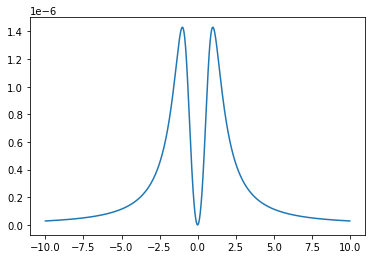

In [16]:
# Graficamos el efecto de la interacción entre a y b.
plt.plot(x, np.array([s['S2'][0,1] for s in sobol_indices]))

El valor del efecto de la interacción es casi 0 siempre por la escala del eje vertical. En $x=0$, la interacción de $a$ y $b$ es casi cero ya que $b$ no tiene ningún efecto sobre $y$. Si nos alejamos ligeramente de $x=0$, vemos que el efecto de la interacción sube drásticamente (aunque sigue siendo cercano a cero) ya que la tasa de crecimiento de $y$ para el intervalo escogido de $x$ es partes iguales el efecto de $a$ y el efecto de $b$. El efecto de la interacción absorbe este fenómeno.

Nuevamente, a medida que $x$ toma valores de magnitud mayor, el efecto de $a$ empieza a ser extremadamente pequeño y por lo tanto no se evidencia un efecto de la interacción.

### Programación lineal

#### Conjuntos

$A$: conjunto de alimentos.

$$
    A = \{\text{Carne}, \text{Papas}, \text{Habichuelas}, \text{Leche}, \text{Guayaba}\}
$$

$N$: conjunto de tipos de calorías.

$$
    N = \{\text{Proteinas}, \text{Grasas}, \text{Glúcidos}\}
$$

#### Parámetros

$c_{a}$: costo por kilo de cada alimento $a \in A$.

$$
c_{a}=\begin{cases} 
      700 & a = \text{Carne}\\
      80 & a = \text{Papas}\\
      250 & a = \text{Habichuelas}\\
      70 & a = \text{Leche}\\
      80 & a = \text{Guayaba}
\end{cases}
$$

$k_{a,n}$: cantidad de calorías que aporta un kilo del alimento $a \in A$ de tipo calórico $n \in N$.

$$
    \begin{matrix}
        k_{\text{Carne},     \text{Proteinas}}= 10 & k_{\text{Carne},      \text{Grasas}}= 10 & k_{\text{Carne},      \text{Glúcidos}}= 0 \\
        k_{\text{Papas},      \text{Proteinas}}= 2 &  k_{\text{Papas},      \text{Grasas}}= 0 &  k_{\text{Papas},      \text{Glúcidos}}= 20 \\
        k_{\text{Habichuelas},\text{Proteinas}}= 1 &  k_{\text{Habichuelas},\text{Grasas}}= 0 &  k_{\text{Habichuelas},\text{Glúcidos}}= 5 \\
        k_{\text{Leche},      \text{Proteinas}}= 5 &  k_{\text{Leche},      \text{Grasas}}= 3 &  k_{\text{Leche},      \text{Glúcidos}}= 5 \\
        k_{\text{Guayaba},    \text{Proteinas}}= 1 &  k_{\text{Guayaba},    \text{Grasas}}= 0 &  k_{\text{Guayaba},    \text{Glúcidos}}= 15
    \end{matrix}
$$

$f_{n}$: porcion de las calorías tipo $n\in N$ que deben constituir una comida.

$$
f_{n}=\begin{cases} 
      0.2 & n = \text{Proteinas}\\
      0.3 & n = \text{Grasas}\\
      0.5 & n = \text{Glúcidos}
\end{cases}
$$

$\text{cal}$: cantidad de calorías en una comida.

$$
    \text{cal} = 800
$$

$\text{per}$: cantidad de pacientes.

$$
    \text{per} = 6
$$

#### Variables

$x_{a}$: cantidad de kilos a utilizar del alimento $a\in A$.

#### Función objetivo

$$
    \min_{x_{a},\forall a \in A}\sum_{a\in A}c_{a}\cdot x_{a}
$$

#### Restricciones

Garantizamos que del total de calorías, se cumpla la porción de cada tipo $n\in N$.

$$
    \sum_{a\in A} k_{a,n}\cdot x_{a} \geq f_{n} \cdot \text{per} \cdot \text{cal},\ \forall n\in N.
$$

Nos aseguramos de que las variables sean siempre positivas.
$$
    x_{a} \geq 0, \ \forall a \in A.
$$

In [23]:
# Declaramos los conjuntos del problema.
Am = {'Carne', 'Papas', 'Habichuelas', 'Leche', 'Guayaba'} # Conjunto de alimentos.
Nm = {'Proteinas', 'Grasas', 'Glúcidos'} # Conjunto de tipos de calorías.

# Declaramos los parámetros del problema.
cm = {'Carne': 700,
      'Papas': 80,
      'Habichuelas': 250,
      'Leche': 70,
      'Guayaba': 80} # Costo por kilo de cada alimento a in A

km = {('Carne',      'Proteinas'): 10, ('Carne',       'Grasas'): 10, ('Carne',       'Glúcidos'): 0,
     ('Papas',       'Proteinas'): 2,  ('Papas',       'Grasas'): 0,  ('Papas',       'Glúcidos'): 20,
     ('Habichuelas', 'Proteinas'): 1,  ('Habichuelas', 'Grasas'): 0,  ('Habichuelas', 'Glúcidos'): 5,
     ('Leche',       'Proteinas'): 5,  ('Leche',       'Grasas'): 3,  ('Leche',       'Glúcidos'): 5,
     ('Guayaba',     'Proteinas'): 1,  ('Guayaba',     'Grasas'): 0,  ('Guayaba',     'Glúcidos'): 15} # Cantidad de calorías de tipo n in N que aporta el alimento a in A.

fm = {'Proteinas': 0.2,
      'Grasas': 0.3,
      'Glúcidos': 0.5} # Porcion de las calorias totales que deben ser de tipo n in N.

calm = 800 # Cantidad de calorias en una comida

perm = 6 # Cantidad de pacientes

In [24]:
# Construimos los parámetros de la función linprog.

c = np.array([*cm.values()]) # Costos de la FO.

A = np.matrix([[km[(a,n)] for a in Am] for n in Nm]) # Matriz de coeficientes

b = np.array([int(round(fm[n] * perm * calm, 0)) for n in Nm]) # RHS de las otras restricciones.

bounds = np.array([(0, None) for a in Am])

In [25]:
# Construimos y resolvemos el modelo.
res = linprog(c=c, # Función de costo.
              A_ub=-A, #Matriz
              b_ub=-b, #Coeficientes libres
              bounds=bounds, #límites de x              
              method="revised simplex") #método

print(res)

     con: array([], dtype=float64)
     fun: 19680.0
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([720.,   0.,   0.])
  status: 0
 success: True
       x: array([  0.,   0.,   0., 144., 120.])


Podemos ver que la comida ideal que garantiza una dieta balanceada y minimiza los costos del hospital contiene únicamente papas y leche. El costo total es de $22720.